In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
sys.path.append('.')
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
import pandas as pd
import warnings

In [4]:
from sklearn import linear_model, kernel_ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.optimize import minimize
from scipy.spatial.distance import squareform, pdist, cdist


In [5]:
np.set_printoptions(precision=6, linewidth=500, threshold=500, suppress=True)

In [6]:
%matplotlib notebook

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import numpy as np
from numpy import exp, eye as I, trace as tr, diag, kron
from numpy.linalg import eigh, eig, inv

import pandas as pd

from scipy.spatial.distance import squareform, pdist, cdist
from scipy.linalg import solve

from typing import Union

from math_utils import bsolve, make_B1, make_B2, make_STi

from sklearn import linear_model
from sklearn.metrics import mean_squared_error

class Model:

    def __init__(self, **params):
        self.params = params
        self.fitted = False
        self.X_pred = np.array([])

    def fit(self, X: np.ndarray, Y: np.ndarray, *args, **kwargs):

        X = self._check_numpy(X)
        Y = self._check_numpy(Y)

        assert X.shape[0] == Y.shape[0], f'X and Y must have the same number of rows ({X.shape[0]} != {Y.shape[0]})'
        assert X.ndim == 2 and Y.ndim == 2

        self.X = X
        self.Y = Y

        self.T, self.N = Y.shape
        self.M = X.shape[1]

        self.fitted = True
        
        return self

    @staticmethod
    def _check_numpy(array: np.ndarray):
        if isinstance(array, pd.DataFrame):
            array = array.values
        assert isinstance(array, np.ndarray), f'Argument must be numpy array, but it is {type(array)}'
        return array

    @staticmethod
    def _warn_params(true_params: list, **params):
        for param in params.keys():
            if param not in true_params:
                print(f'WARNING: UNKNOWN PARAMETER {param}')

    def set_params(self, **params):
        for param, value in params.items():
            self.params[param] = value

    def predict(self, X: np.ndarray):

        if not self.fitted:
            raise ValueError('Attempting to make prediction before model has been fit')

        X = self._check_numpy(X)
        assert X.shape[1] == self.X.shape[1]

        self.X_pred = X

    def MSE(self, X: np.ndarray, Y: np.ndarray):
        return mean_squared_error(Y, self.predict(X))

    def __repr__(self):
        return 'Model()'
    
    
class NaiveEstimator(Model):

    def __init__(self):
        super().__init__()
        self.fitted = True

    def predict(self, X):
        super().predict(X)
        return X[[col for col in X if ' AA' in col]]

    def __repr__(self):
        return 'NaiveEstimator()'


class SKLearnModel(Model):

    def __init__(self, **params):
        super().__init__(**params)
        self.model = None

    def fit(self, X: np.ndarray, Y: np.ndarray, *args, **kwargs):
        super().fit(X, Y)
        self.model.fit(X, Y)
        return self

    def set_params(self, **params):
        super().set_params(**params)

        self._warn_params(['alpha'], **params)

        self.model.set_params(**self.params)
        self.model.fit(self.X, self.Y)

        return self

    def predict(self, X: np.ndarray):
        super().predict(X)
        return self.model.predict(self.X_pred)


class RidgeRegression(SKLearnModel):
    """
    params:
        alpha (float)
    """

    def __init__(self, alpha: float):
        super().__init__(alpha=alpha)
        self.model = linear_model.Ridge(alpha=alpha, fit_intercept=False)

    def __repr__(self):
        return 'RidgeRegression(alpha={alpha:.4f})'.format(**self.params)
    
    def set_params(self, alpha):
        return super().set_params(alpha=alpha)
    
    
class LinearRegression(SKLearnModel):
    """
    params:
        alpha (float)
    """

    def __init__(self):
        super().__init__()
        self.model = linear_model.LinearRegression(fit_intercept=False)

    def __repr__(self):
        return 'LinearRegression()'
    
    def set_params(self, alpha):
        return super().set_params(alpha=alpha)



class LassoRegression(SKLearnModel):
    """
    params:
        alpha (float)
    """

    def __init__(self, alpha: float):
        super().__init__(alpha=alpha)
        self.model = linear_model.Lasso(alpha=alpha, fit_intercept=False)

    def __repr__(self):
        return 'LassoRegression(alpha={alpha:.4f})'.format(**self.params)
    
    def set_params(self, alpha):
        return super().set_params(alpha=alpha)

filter_functions = {'inverse': lambda lamL, beta: (1 + beta * lamL) ** -1,
                    'exponential': lambda lamL, beta: exp(-beta * lamL),
                    'ReLu': lambda lamL, beta: np.maximum(1 - beta * lamL, 0),
                    'sigmoid': lambda lamL, beta: 2 * (1 + exp(beta * lamL)) ** -1,
                    'cosine': lambda lamL, beta: np.cos(lamL * np.pi / (2 * lamL.max())) ** beta,
                    'cut-off': lambda lamL, beta: (lamL <= 1 / beta).astype(int) if beta != 0 else np.ones_like(lamL)}


class GraphRegression(Model):
    """
    params:
        gamma  (float)
        beta   (float)
        filter (string)
    """

    def __init__(self, gamma: float, beta: float, filter: str = 'sigmoid'):
        super().__init__(gamma=gamma, beta=beta, filter=filter)

    def fit(self, X: np.ndarray, Y: np.ndarray, L: np.ndarray = None, *args, **kwargs):
        super().fit(X, Y)

        self.lamX, self.S = np.linalg.eigh(self.X.T @ self.X)

        self.L = self._check_numpy(L)
        self.lamL, self.U = np.linalg.eigh(self.L)

        self.hh = filter_functions[self.params['filter']](self.lamL, self.params['beta']) ** 2
        self.G = self.hh[None, :] / (self.hh[None, :] * self.lamX[:, None] + self.params['gamma'])

        self.WW = self.S.T @ self.X.T @ self.Y @ self.U
        self.W = self.S @ (self.G * self.WW) @ self.U.T

        return self

    def set_params(self, gamma=None, beta=None, filter=None):
        
        params = {key: value for key, value in zip(['filter', 'beta', 'gamma'], [filter, beta, gamma]) if value is not None}
        
        super().set_params(**params)

        self._warn_params(['filter', 'gamma', 'beta'], **params)

        if 'filter' in params or 'beta' in params:
            self.hh = filter_functions[self.params['filter']](self.lamL, self.params['beta']) ** 2
        if 'filter' in params or 'beta' in params or 'gamma' in params:
            self.G = self.hh[None, :] / (self.hh[None, :] * self.lamX[:, None] + self.params['gamma'])
            self.W = self.S @ (self.G * self.WW) @ self.U.T

        return self

    def predict(self, X: np.ndarray):
        super().predict(X)
        return self.X_pred @ self.W

    def __repr__(self):
        return "GraphRegression(gamma={gamma:.4f}, beta={beta:.4f}, filter='{filter}')".format(**self.params)


class KernelGraphRegression(Model):
    """
    params:
        gamma       (float)
        beta        (float)
        kernel_std  (float)
        filter      (string)
    """

    def __init__(self, gamma: float, beta: float, kernel_std: float = 50, filter: str = 'sigmoid'):
        super().__init__(gamma=gamma, beta=beta, kernel_std=kernel_std, filter=filter)
        self.D_pred = np.array([])

    def fit(self, X: np.ndarray, Y: np.ndarray, L: np.ndarray = None, *args, **kwargs):
        super().fit(X, Y)

        self.L = self._check_numpy(L)
        assert self.L.shape[0] == self.L.shape[1]
        assert self.L.shape[0] == self.Y.shape[1]
        self.lamL, self.U = np.linalg.eigh(self.L)

        self.D = squareform(pdist(self.X, metric='sqeuclidean'))
        self.K = np.exp(- self.D / self.params['kernel_std'] ** 2)
        self.lamK, self.V = np.linalg.eigh(self.K)

        self.hh = filter_functions[self.params['filter']](self.lamL, self.params['beta']) ** 2
        self.G = self.hh[None, :] / (self.hh[None, :] * self.lamK[:, None] + self.params['gamma'])

        self.PP = self.V.T @ self.Y @ self.U
        self.Psi = self.V @ (self.G * self.PP) @ self.U.T

        return self

    def set_params(self, **params):
        super().set_params(**params)

        self._warn_params(['filter', 'gamma', 'beta', 'kernel_std'], **params)

        if 'filter' in params or 'beta' in params:
            self.hh = filter_functions[self.params['filter']](self.lamL, self.params['beta']) ** 2
        if 'kernel_std' in params:
            self.K = np.exp(- self.D / self.params['kernel_std'] ** 2)
            self.lamK, self.V = np.linalg.eigh(self.K)
            self.PP = self.V.T @ self.Y @ self.U
        if 'filter' in params or 'beta' in params or 'gamma' in params or 'kernel_std' in params:
            self.G = self.hh[None, :] / (self.hh[None, :] * self.lamK[:, None] + self.params['gamma'])
            self.Psi = self.V @ (self.G * self.PP) @ self.U.T

        return self

    def predict(self, X: np.ndarray):

        X = self._check_numpy(X)

        # if the new feature matrix, X, is exactly the same as one previously seen, there's no need to recompute D
        if X.shape == self.X_pred.shape and (self.X_pred == X).all():
            return exp(-self.D_pred / self.params['kernel_std'] ** 2) @ self.Psi

        else:
            super().predict(X)
            self.D_pred = cdist(self.X_pred, self.X, metric='sqeuclidean')
            return exp(-self.D_pred / self.params['kernel_std'] ** 2) @ self.Psi

    def __repr__(self):
        return "KernelGraphRegression(gamma={gamma:.4f}, beta={beta:.4f}, kernel_std={kernel_std:.2f}, filter='{filter}')".format(**self.params)


class GLSKernelGraphRegression(Model):
    """
    params:
        gamma       (float)
        beta        (float)
        kernel_std  (float)
        alpha       (float)
        filter      (string)
    """
    
    def __repr__(self):
        return "GLSKernelGraphRegression(gamma={gamma:.4f}, beta={beta:.4f}, kernel_std={kernel_std:.2f}, alpha={alpha:.2f}, filter='{filter}')".format(**self.params)

    def __init__(self, gamma: float, beta: float, kernel_std: float=50, alpha: float=5, filter: str='sigmoid'):

        MAX_ITERS = 60
        FTOL = 1e-4

        super().__init__(gamma=gamma, beta=beta, kernel_std=kernel_std, alpha=alpha,
                         filter=filter, max_iters=MAX_ITERS, ftol=FTOL)

        self.covariace_estimator = CovarianceEstimator(alpha)


    def fit(self, X: np.ndarray, Y: np.ndarray, L: np.ndarray = None, *args, **kwargs):
        super().fit(X, Y)

        self.L = self._check_numpy(L)
        assert self.L.shape[0] == self.L.shape[1]
        assert self.L.shape[0] == self.Y.shape[1]
        self.lamL, self.U = np.linalg.eigh(self.L)

        self.D = squareform(pdist(self.X, metric='sqeuclidean'))
        self.K = np.exp(- self.D / self.params['kernel_std'] ** 2)
        self.lamK, self.V = np.linalg.eigh(self.K)

        self.hh = filter_functions[self.params['filter']](self.lamL, self.params['beta']) ** 2
        self.HH = self.U @ (self.hh.reshape(-1, 1) * self.U.T)
        self.G = self.hh[None, :] / (self.hh[None, :] * self.lamK[:, None] + self.params['gamma'])

        self.Psi, self.theta, self.SN = self.solve_GLS()
        
        return self


    def estimate_Psi_GLS(self, theta: float, SN: np.ndarray):

        STi = make_STi(self.T, theta)
        lamN, R = eig(bsolve(SN, self.HH, assume_a='pos'))
        lamT, Q = eig(self.K @ STi)
        J = lamN.reshape(1, -1) / (lamN.reshape(1, -1) * lamT.reshape(-1, 1) + self.params['gamma'])

        return np.real(STi @ Q @ (J * solve(Q, bsolve(R.T, self.Y))) @ R.T)


    def solve_GLS(self):

        Psi = self.V @ (self.G * (self.V.T @ self.Y @ self.U)) @ self.U.T
        Y_est = self.K @ Psi
        SN, theta = self.covariace_estimator.estimate(self.Y - Y_est)

        dtheta = 1
        it = 1

        while abs(dtheta) > self.params['ftol']:

            Psi = self.estimate_Psi_GLS(theta, SN)
            Y_est = self.K @ Psi
            SN, theta_ = self.covariace_estimator.estimate(self.Y - Y_est)

            dtheta = theta - theta_
            theta = theta_
            it += 1
            if it >= self.params['max_iters']:
                print('max iterations reached')
                break

        return Psi, theta, SN

    def predict(self, X: np.ndarray):

        X = self._check_numpy(X)

        # if the new feature matrix, X, is exactly the same as one previously seen, there's no need to recompute D
        if X.shape == self.X_pred.shape and (self.X_pred == X).all():
            return exp(-self.D_pred / self.params['kernel_std'] ** 2) @ self.Psi

        else:
            super().predict(X)
            self.D_pred = cdist(self.X_pred, self.X, metric='sqeuclidean')
            return exp(-self.D_pred / self.params['kernel_std'] ** 2) @ self.Psi
        
    def set_params(self, **params):
        super().set_params(**params)

        self._warn_params(['filter', 'gamma', 'beta', 'kernel_std', 'alpha'], **params)

        if 'filter' in params or 'beta' in params:
            self.hh = filter_functions[self.params['filter']](self.lamL, self.params['beta']) ** 2
        if 'kernel_std' in params:
            self.K = np.exp(- self.D / self.params['kernel_std'] ** 2)
        if 'filter' in params or 'beta' in params or 'gamma' in params or 'kernel_std' in params:
            self.G = self.hh[None, :] / (self.hh[None, :] * self.lamK[:, None] + self.params['gamma'])
        if 'alpha' in params:
            self.covariace_estimator = CovarianceEstimator(self.params['alpha'])
            
        self.Psi, self.theta, self.SN = self.solve_GLS()

        return self
    
    def get_laplace_uncertainty(self, X: np.ndarray):
        
        # if the new feature matrix, X, is exactly the same as one previously seen, there's no need to recompute D
        if X.shape == self.X_pred.shape and (self.X_pred == X.values).all():
            K_ = exp(-self.D_pred / self.params['kernel_std'] ** 2)

        else:
            super().predict(X)
            self.D_pred = cdist(self.X_pred, self.X, metric='sqeuclidean')
            K_ = exp(-self.D_pred / self.params['kernel_std'] ** 2)
            
        lamN, R = eig(bsolve(self.SN, self.HH, assume_a='pos'))
        lamT, Q = eig(self.K @ make_STi(self.T, self.theta))
        J = lamN.reshape(1, -1) / (lamN.reshape(1, -1) * lamT.reshape(-1, 1) + self.params['gamma'])
        
        Ri, Qi, Ki = inv(R), inv(Q), inv(self.K)
            
        return ((K_ @ Qi.T) * (K_ @ Ki @ Q)) @ J @ (R.T * (Ri @ self.SN))


class CovarianceEstimator:

    def __init__(self, alpha: float):
        self.alpha = alpha
        
    def get_rho(self, SN_MLE):
        st = tr(SN_MLE @ SN_MLE)
        ts = tr(SN_MLE) ** 2
        u = ts + st * (self.T - 2) / self.T
        d = (self.T + 2) * (st - ts / self.N)
        return min(u / d, 1)

    def estimate_SN(self, theta: float):
        SN_MLE = (self.EE - theta * self.EB1E + theta ** 2 * self.EB2E) / (self.T * (1 - theta ** 2))
        rho = self.get_rho(SN_MLE)
        return (1 - rho) * SN_MLE + rho * tr(SN_MLE) * I(self.N) / self.T

    @staticmethod
    def real_root(roots):
        return np.real(roots[np.argmin(np.abs(roots.imag))])

    def estimate_theta(self, SN):
        SNiE = solve(SN, self.E.T, assume_a='pos')
        a = (self.E.T * SNiE).sum()
        b = (self.E.T * (SNiE @ self.B1)).sum()
        c = (self.E.T * (SNiE @ self.B2)).sum()
        roots = np.roots([self.N * (1 - self.T), b / 2, self.N * (self.T - 1) - a - c -  self.N * self.T * self.alpha, b / 2])
        return self.real_root(roots)

    def estimate(self, E, tol=1e-3):
        self.E = E
        self.T, self.N = E.shape
        self.B1 = make_B1(self.T, sparse=True)
        self.B2 = make_B2(self.T, sparse=True)

        self.EE = E.T @ E
        self.EB1E = E.T @ self.B1 @ E
        self.EB2E = E.T @ self.B2 @ E

        dtheta = 1
        theta = 0
        SN = None

        while abs(dtheta) > tol:
            SN = self.estimate_SN(theta)
            dtheta = self.estimate_theta(SN) - theta
            theta += dtheta

        return SN, theta
    
    
class MultiModel:
    
    def __init__(self, mod, **init_params):
        self.mods = [mod(**init_params) for i in range(4)]
        
    def fit(self, X_trains, Y_trains, L=None):
        for i in range(4):
            self.mods[i].fit(X_trains[i], Y_trains[i], L)
        return self
    
    def set_params(self, *params, **kwparams):
        for i in range(4):
            self.mods[i].set_params(*params, **kwparams) 
        return self
            
    def MSE(self, X_valids, Y_valids):
        return sum([self.mods[i].MSE(X_valids[i], Y_valids[i]) for i in range(4)]) / 4
    
    def __repr__(self):
        return 'MultiModel({})'.format(self.mods[0])

In [10]:
from data import Features

feat = Features()

In [11]:
data = {}

for pollutant in feat.pollutants:
    
    Y = feat.get_Y(pollutant)
    X = feat.get_X(y_metric=pollutant, transform=True, use_PCA=True, PCA_variance_level=0.9)
    X['const'] = 1
    L1 = feat.get_L(pollutant, m1=14, m2=0.0016, normed=False)
    L2 = feat.get_L(pollutant, m1=14, m2=0.0016, normed=True)

    print(pollutant)
    data[pollutant] = (X, Y, L1, L2)

CO
SO2
NO2
Ozone
PM2.5
PM10
NO


In [14]:
def get_data(pollutant):
    
    X, Y, L1, L2 = data[pollutant]
    
    X.loc[:, 'cyclic 1'] = np.sin(2* np.pi * (X.index - pd.to_datetime('2017-12-21')).days / 365)
    X.loc[:, 'cyclic 2'] = np.cos(2* np.pi * (X.index - pd.to_datetime('2017-12-21')).days / 365)
    X.loc[:, 'const'] = 1

    X_test, Y_test = X.iloc[219 * 4: 219 * 5, :], Y.iloc[219 * 4: 219 * 5, :]
    X_train_total, Y_train_total = X.iloc[: 219 * 4, :], Y.iloc[: 219 * 4, :]

    X_valids = [X.iloc[219 * i: 219 * (i + 1), :] for i in range(4)]
    Y_valids = [Y.iloc[219 * i: 219 * (i + 1), :] for i in range(4)]
    X_trains = [pd.concat([X.iloc[:219 * i, :], X.iloc[219 * (i + 1):, :]]) for i in range(4)]
    Y_trains = [pd.concat([Y.iloc[:219 * i, :], Y.iloc[219 * (i + 1):, :]]) for i in range(4)]
    
    return X_trains, Y_trains, X_valids, Y_valids, X_train_total, Y_train_total, X_test, Y_test, L2

In [15]:
X_trains, Y_trains, X_valids, Y_valids, X_train_total, Y_train_total, X_test, Y_test, L = get_data('CO')

In [16]:
all_params = []

def obj(params):
    err =  GLSKernelGraphRegression(gamma=np.exp(params[0]), beta=np.exp(params[1]), kernel_std=np.exp(params[2]), alpha=10+np.exp(params[3])).fit(X_train_total, Y_train_total, L).MSE(X_test, Y_test)
    print(params, f'{err:.4f}')
    all_params.append(params)
    return err

minimize(obj, x0=[-4.97,  0.92, 5.13, 3.688], tol=1e-5, method='Nelder-Mead')

[-4.97   0.92   5.13   3.688] 0.3217
[-5.2185  0.92    5.13    3.688 ] 0.3115
[-4.97   0.966  5.13   3.688] 0.3351


KeyboardInterrupt: 

In [17]:
models = {'CO':    {'GLS':    (GLSKernelGraphRegression, dict(gamma=np.exp(-7.23929), beta=np.exp(-0.857856), kernel_std=np.exp(6.973556), filter='sigmoid', alpha=60.5)),
                    'KGR':    (KernelGraphRegression, dict(gamma=np.exp(-26.099668), beta=np.exp(-0.753166), kernel_std=np.exp(15.309744), filter='sigmoid')),
                    'Graph':  (GraphRegression, dict(gamma=np.exp(4.58), beta=np.exp(-27.717673), filter='sigmoid')), 
                    'Ridge':  (RidgeRegression, dict(alpha=104.0501)), 
                    'Lasso':  (LassoRegression, dict(alpha=0.00125)), 
                    'Linear': (LinearRegression, dict()), 
                    'Naive':  (NaiveEstimator, dict())},

          'SO2':   {'GLS':    (GLSKernelGraphRegression, dict(gamma=np.exp(-10.453592), beta=np.exp(-2.396809), kernel_std=np.exp( 8.782283), filter='sigmoid', alpha=50)),
                    'KGR':    (KernelGraphRegression, dict(gamma=np.exp(-26.659676), beta=np.exp(-12.793335), kernel_std=np.exp(15.91502), filter='sigmoid')), 
                    'Graph':  (GraphRegression, dict(gamma=np.exp(4.180376), beta=np.exp(-36.364321), filter='sigmoid')), 
                    'Ridge':  (RidgeRegression, dict(alpha=66.8977)), 
                    'Lasso':  (LassoRegression, dict(alpha=0.0011)), 
                    'Linear': (LinearRegression, {}), 
                    'Naive':  (NaiveEstimator, {})},

          'NO2':   {'GLS':    (GLSKernelGraphRegression, dict(gamma=np.exp(-4.627787 ), beta=np.exp(1.107156), kernel_std=np.exp(4.835443), filter='sigmoid', alpha=50)),
                    'KGR':    (KernelGraphRegression, dict(gamma=np.exp(-2.043001), beta=np.exp(-2.326189), kernel_std=np.exp(4.155446), filter='sigmoid')), 
                    'Graph':  (GraphRegression, dict(gamma=np.exp(5.33878 ), beta=np.exp(-0.312068), filter='sigmoid')), 
                    'Ridge':  (RidgeRegression, dict(alpha=584.3299)), 
                    'Lasso':  (LassoRegression, dict(alpha=0.00345)), 
                    'Linear': (LinearRegression, {}), 
                    'Naive':  (NaiveEstimator, {})},

          'Ozone': {'GLS':    (GLSKernelGraphRegression, dict(gamma=np.exp(-4.975944), beta=np.exp(0.921428), kernel_std=np.exp(5.138048), filter='sigmoid', alpha=50)),
                    'KGR':    (KernelGraphRegression, dict(gamma=np.exp(-1.76086), beta=np.exp(-3.917019), kernel_std=np.exp(4.383881), filter='sigmoid')), 
                    'Graph':  (GraphRegression, dict(gamma=np.exp(6.326141), beta=np.exp(-1.916136), filter='sigmoid')), 
                    'Ridge':  (RidgeRegression, dict(alpha=851.0065)), 
                    'Lasso':  (LassoRegression, dict(alpha=0.00440)), 
                    'Linear': (LinearRegression, {}), 
                    'Naive':  (NaiveEstimator, {})},

          'PM2.5': {'GLS':    (GLSKernelGraphRegression, dict(gamma=np.exp(-3.932973), beta=np.exp(0.590676), kernel_std=np.exp(4.977854), filter='sigmoid', alpha=50)),
                    'KGR':    (KernelGraphRegression, dict(gamma=np.exp(-2.042597), beta=np.exp(-4.323814), kernel_std=np.exp(4.4173), filter='sigmoid')), 
                    'Graph':  (GraphRegression, dict(gamma=647.6025, beta=-0.0216, filter='sigmoid')), 
                    'Ridge':  (RidgeRegression, dict(alpha=450.6857)), 
                    'Lasso':  (LassoRegression, dict(alpha=0.00560)), 
                    'Linear': (LinearRegression, {}), 
                    'Naive':  (NaiveEstimator, {})}, 

          'PM10':  {'GLS':    (GLSKernelGraphRegression, dict(gamma=np.exp(-6.082556), beta=np.exp(0.91067), kernel_std=np.exp(5.685753), filter='sigmoid', alpha=50)),
                    'KGR':    (KernelGraphRegression, dict(gamma=np.exp(-1.837367), beta=np.exp(-0.441134), kernel_std=np.exp(4.032386), filter='sigmoid')), 
                    'Graph':  (GraphRegression, dict(gamma=np.exp(6.08161), beta=np.exp(-31.002168), filter='sigmoid')), 
                    'Ridge':  (RidgeRegression, dict(alpha=639.6413)), 
                    'Lasso':  (LassoRegression, dict(alpha=0.00960)), 
                    'Linear': (LinearRegression, {}), 
                    'Naive':  (NaiveEstimator, {})},

          'NO':    {'GLS':    (GLSKernelGraphRegression, dict(gamma=np.exp(-4.649288), beta=np.exp(0.999797), kernel_std=np.exp(4.855422), filter='sigmoid', alpha=60)),
                    'KGR':    (KernelGraphRegression, dict(gamma=np.exp(-2.325413), beta=np.exp(-0.052258), kernel_std=np.exp(4.101832), filter='sigmoid')), 
                    'Graph':  (GraphRegression, dict(gamma=np.exp(6.350094), beta=np.exp(-27.717673), filter='sigmoid')), 
                    'Ridge':  (RidgeRegression, dict(alpha=557.0934)), 
                    'Lasso':  (LassoRegression, dict(alpha=0.00860)), 
                    'Linear': (LinearRegression, {}), 
                    'Naive':  (NaiveEstimator, {})}, 
}


def get_trained_models(pollutants=None, estimators=None):
    
    if estimators is None:
        estimators = list(models['CO'].keys())
    else:
        estimators = [est for est in list(models['CO'].keys()) if est in estimators]
        
    if pollutants is None:
        pollutants = list(models.keys())
    else:
        pollutants = [pol for pol in list(models.keys()) if pol in pollutants]
    
    trained_models = {}
    
    for pollutant, ests in models.items():
        
        trained_models[pollutant] = {}
        
        X_trains, Y_trains, X_valids, Y_valids, X_train_total, Y_train_total, X_test, Y_test, L = get_data(pollutant)
        
        for model_name, (est, params) in ests.items():
            
            trained_models[pollutant][model_name] = est(**params).fit(X_train_total, Y_train_total, L)
            
    return trained_models


def get_scores():
    
    pollutants = list(models.keys())
    estimators = list(models['CO'].keys())
    
    vali_score = pd.DataFrame(columns=pollutants, index=estimators)
    test_score = pd.DataFrame(columns=pollutants, index=estimators)

    for pollutant, ests in models.items():
        
        X_trains, Y_trains, X_valids, Y_valids, X_train_total, Y_train_total, X_test, Y_test, L = get_data(pollutant)
        
        for name, (est, params) in ests.items():
            
            vali_score.loc[name, pollutant] = MultiModel(est, **params).fit(X_trains, Y_trains, L).MSE(X_valids, Y_valids)
            test_score.loc[name, pollutant] = est(**params).fit(X_train_total, Y_train_total, L).MSE(X_test, Y_test)
            
    return vali_score, test_score
            

In [18]:
trained_models = get_trained_models(estimators=['GLS', 'KGR', 'Ridge'])

<IPython.core.display.Javascript object>


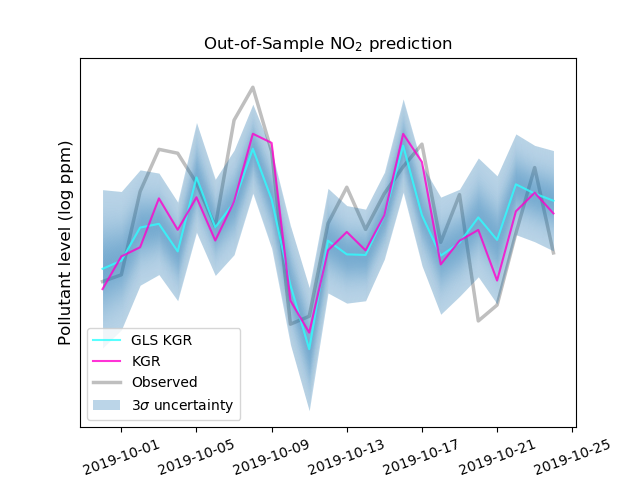

[0.1606   0.14042  0.117043 0.102972 0.100078 0.111499 0.097599 0.106058 0.090385 0.099147 0.120559 0.125025 0.10617  0.098992 0.092956 0.088089 0.094788 0.102078 0.118856 0.108632 0.120542 0.130024 0.102226 0.09774  0.101809]
[0.004818 0.004213 0.003511 0.003089 0.003002 0.003345 0.002928 0.003182 0.002712 0.002974 0.003617 0.003751 0.003185 0.00297  0.002789 0.002643 0.002844 0.003062 0.003566 0.003259 0.003616 0.003901 0.003067 0.002932 0.003054]


In [21]:
def make_uncertainty_plot():
    
    fig, ax = plt.subplots()

    pollutant = 'NO2'
    station = 20
    
    start = 125
    stop = 150
    
    X_trains, Y_trains, X_valids, Y_valids, X_train_total, Y_train_total, X_test, Y_test, L = get_data(pollutant)

    GLS = trained_models[pollutant]['GLS']
    KGR = trained_models[pollutant]['KGR']
    RDG = trained_models[pollutant]['Ridge']
 
    t = Y_test.index[start:stop]
    GLS_pred = GLS.predict(X_test)[start:stop, station]
    KGR_pred =  KGR.predict(X_test)[start:stop, station]
    RDG_pred = RDG.predict(X_test)[start:stop, station]
    
    GLS_unc = GLS.get_laplace_uncertainty(X_test)[start:stop, station] ** 0.5
    
    print(GLS_unc)

    Y_obs = Y_test.values[start:stop, station]

    plt.plot(t, GLS_pred, label='GLS KGR', color='#2effff', alpha=0.8)
    plt.plot(t, KGR_pred, label='KGR', color='#ff00cc', alpha=0.8)
#     plt.plot(t, RDG_pred, label='Ridge', color='#ff6201', alpha=0.8)
    plt.plot(t, Y_obs, color='gray', zorder=0, lw=2.5, alpha=0.5, label='Observed')

    N = 100
    ds = 3 * GLS_unc / N
    print(ds)
    
    plt.fill_between(t, GLS_pred - 3 * GLS_unc, GLS_pred + 3 * GLS_unc, alpha=0.3, color='tab:blue', lw=0, label='3$\sigma$ uncertainty')


    for i in range(N):
        
        p = 0.5 * np.exp(- 0.5 * 8 * i ** 2 / N ** 2)
        
        plt.fill_between(t, GLS_pred + i * ds, GLS_pred + (i + 1) * ds, alpha=p, color='tab:blue', lw=0)
        plt.fill_between(t, GLS_pred - i * ds, GLS_pred - (i + 1) * ds, alpha=p, color='tab:blue', lw=0)

        
    plt.xticks(rotation = 20) 
    plt.yticks([])

    plt.ylabel('Pollutant level (log ppm)', size='large')

    plt.savefig('')
    plt.legend(loc='lower-right')

    plt.ylim(-1.2, 1.05)

    plt.title('Out-of-Sample NO$_2$ prediction', size='large')
    
    ax.set_xticks(ax.get_xticks()[1:])

    plt.savefig('prediction.pdf', dpi=72)
    
make_uncertainty_plot()

In [427]:
s = 2
x = 1



0.7788007830714049

array([0.383395, 0.340316, 0.320345, 0.281032, 0.271356, 0.283536, 0.268823, 0.22767 , 0.3268  , 0.212696, 0.171632, 0.152382, 0.248226, 0.36754 , 0.408231, 0.198559, 0.173903, 0.198415, 0.208456, 0.317767, 0.317375, 0.24031 , 0.274439, 0.237053, 0.246664, 0.336805, 0.491864, 0.324175, 0.508459, 0.204145, 0.294345, 0.19567 , 0.319169, 0.331067, 0.244982, 0.275888, 0.25973 , 0.450812, 0.288866, 0.326519, 0.366602, 0.335675, 0.357317, 0.294821, 0.326701, 0.295777, 0.330229, 0.557137, 0.410542,
       0.281784, 0.340077, 0.287799, 0.389802, 0.288645, 0.272248, 0.288597, 0.359057, 0.231934, 0.310563, 0.326856, 0.297285, 0.361339, 0.249223, 0.244126, 0.340639, 0.288621, 0.210357, 0.335245, 0.238335, 0.184156, 0.30977 , 0.173271, 0.446897, 0.305903, 0.293028, 0.287483, 0.285203, 0.234741, 0.276349])

In [312]:
vali_score, test_score = get_scores()

In [313]:
vali_score

,CO,SO2,NO2,Ozone,PM2.5,PM10,NO
GLS,0.281947,0.305258,0.189364,0.274674,0.430506,0.368081,0.295711
KGR,0.293121,0.322278,0.17941,0.250308,0.416302,0.351526,0.279832
Graph,0.289984,0.320721,0.187995,0.258543,0.432397,0.381986,0.285923
Ridge,0.289937,0.320708,0.186419,0.257645,0.430672,0.380115,0.285916
Lasso,0.283721,0.298323,0.192227,0.276818,0.415663,0.359783,0.271442
Linear,0.702854,0.993468,0.75183,1.49757,1.39617,1.24193,0.987352
Naive,0.246959,0.193494,0.26214,0.315456,0.47171,0.520661,0.377994


In [328]:
test_score

,CO,SO2,NO2,Ozone,PM2.5,PM10,NO
GLS,0.23512,0.27201,0.159885,0.257409,0.317103,0.270024,0.270867
KGR,0.252283,0.291924,0.152519,0.240602,0.314847,0.25849,0.261395
Graph,0.252293,0.297562,0.163543,0.250751,0.332228,0.291586,0.278533
Ridge,0.252858,0.297567,0.165162,0.251328,0.330643,0.293415,0.278538
Lasso,0.242228,0.281036,0.160601,0.251272,0.327178,0.26918,0.260773
Linear,0.767057,0.864744,0.722721,2.37012,1.46094,1.09938,0.804585
Naive,0.227023,0.170308,0.24264,0.306104,0.377728,0.361007,0.364536


In [346]:
x = np.array([1, 2, 4])
s = 2
K = np.exp(-squareform(pdist(x[:, None], metric='sqeuclidean')) / s ** 2)
K

array([[1.      , 0.778801, 0.105399],
       [0.778801, 1.      , 0.367879],
       [0.105399, 0.367879, 1.      ]])

In [347]:
np.linalg.eigh(K)

(array([0.175548, 0.919088, 1.905363]),
 array([[-0.650581, -0.419071, -0.633344],
        [ 0.720999, -0.078875, -0.688432],
        [-0.238547,  0.904521, -0.353465]]))

In [48]:

def plot_pred(pollutant):
    
    plt.figure()
    
    X_trains, Y_trains, X_valids, Y_valids, X_train_total, Y_train_total, X_test, Y_test, L1 = get_data(pollutant)
    
    plt.plot(Y_test.iloc[:, 0].values, label='True')
    
    for name, (est, params) in models[pollutant].items():
        
        if name in ['KGR', 'Graph', 'Lasso']:

            pred = est(**params).fit(X_train_total, Y_train_total, L1).predict(X_test)


            if isinstance(pred, np.ndarray):
                plt.plot(pred[:, 0], label=name, lw=1)
            else:
                plt.plot(pred.iloc[:, 0].values, label=name, lw=1)
        
    plt.legend()
    plt.show()
        
          


<IPython.core.display.Javascript object>


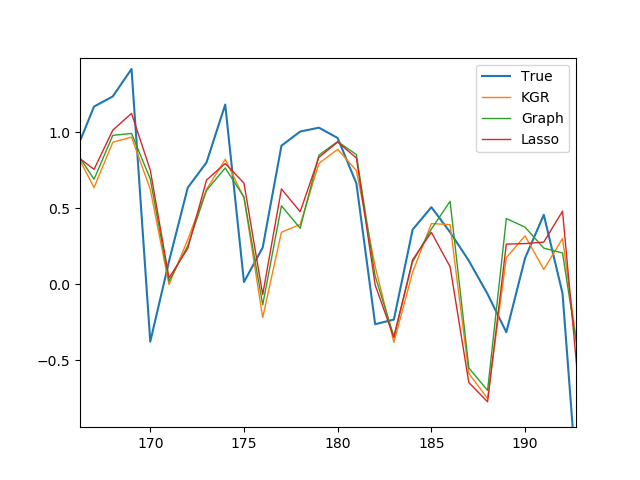

In [49]:
plot_pred('NO2')  

In [146]:
def get_best_KGR_estimator(X_trains, Y_trains, X_valids, Y_valids, L):
    
    params = []
    funs = []
    
    reg = MultiModel(KernelGraphRegression, gamma=0.0075, beta=-0.1103, kernel_std=266.0, filter='sigmoid')
    reg.fit(X_trains, Y_trains, L)
    out = None
    
    for K_std in np.linspace(40, 500, 231):
        
        reg.set_params(kernel_std=K_std)
        
        def objective(params):
            return reg.set_params(gamma=params[0], beta=params[1]).MSE(X_valids, Y_valids)
        
        if out is None or ((out.x > 5).any() or (out.x < -5).any()):
            out = minimize(objective, x0=np.array([0.05, 0.05]), tol=1e-5, method='Nelder-Mead')
        else:
            out = minimize(objective, x0=out.x, tol=1e-5, method='Nelder-Mead')
        
        funs.append(out.fun)
        params.append(list(out.x) + [K_std])
        print(f'{funs[-1]:.4f}', params[-1])
        
        try:
            if funs[-2] - funs[-1] < 0.00001:
                break
            
        except:
            pass
        
    best_params = params[np.argmin(funs)]

        
    return reg.set_params(gamma=best_params[0], beta=best_params[1], kernel_std=best_params[2])

In [147]:
def get_best_estimator(model, X_trains, Y_trains, X_valids, Y_valids, L=None):
    
    
    if model in ['Graph', 'Ridge', 'Lasso']:
        
        if model == 'Graph':
            reg = MultiModel(GraphRegression, gamma=500, beta=0.1, filter='sigmoid')
        elif model == 'Ridge':
            reg = MultiModel(RidgeRegression, alpha=500)
        else:
            reg = MultiModel(LassoRegression, alpha=1)
                
        reg.fit(X_trains, Y_trains, L)
        out = None
        
        def objective(params):
            print(params)
            return reg.set_params(*params).MSE(X_valids, Y_valids)
        
        if out is None:
            out = minimize(objective, x0=np.array(list(reg.mods[0].params.values())[:2]), tol=1e-7, method='Nelder-Mead')
        else:
            out = minimize(objective, x0=out.x, tol=1e-7, method='Nelder-Mead')
        
        return reg.set_params(*out.x)
        
    elif model == 'Linear':
        return LinearRegression().fit(X_train, Y_train)
    
    elif model == 'Naive':
            
        return NaiveEstimator()

<IPython.core.display.Javascript object>


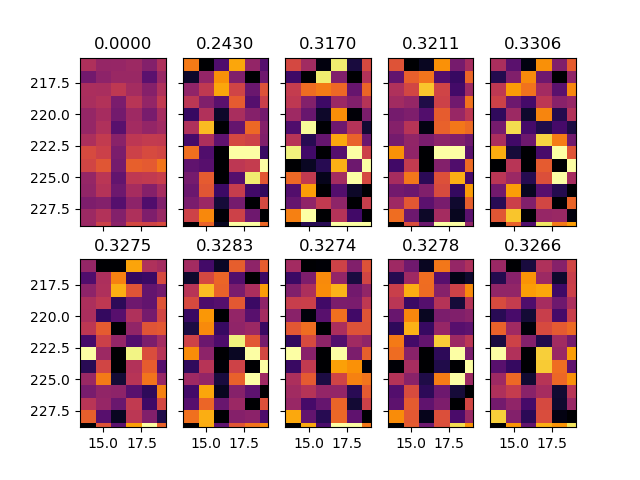

In [184]:
fig, axes = plt.subplots(nrows = 2, ncols=5, sharex =True, sharey=True )

k = 0 
for i in range(2):
    for j in range(5):
        
        axes[i, j].imshow(all_psis[k], cmap='inferno', vmin=-3, vmax=3)
        axes[i, j].set_title('{:.4f}'.format(all_thetas[k]))
        axes[i, j].set_aspect('auto')
        k += 1

<IPython.core.display.Javascript object>


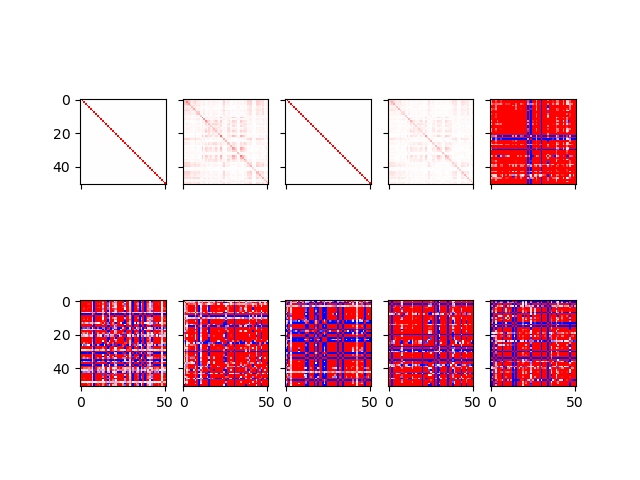

In [180]:
fig, axes = plt.subplots(nrows = 2, ncols=5, sharex =True, sharey=True )

k = 0 
for i in range(2):
    for j in range(5):
        
        axes[i, j].imshow(all_SNs[k], cmap='bwr', vmin=-1, vmax=1)
        axes[i, j].set_aspect('equal')
        k += 1